# Desafio 5 - PFSP LS - Dupla 09

**Integrantes:**

* Lucas Hideki Takeuchi Okamura NUSP: 9274315

* Thales Arantes Kerche Nunes NUSP: 10769372

**Objetivo**

* Programar a heurística Busca Local (LS - Local Search) para explorar a vizinhança de uma solução inicial para o problema de minimização do makespan em um flow shop com m máquinas.

**Descrição**

* A busca local inicia-se com uma solução inicial (no nosso caso, do PFSP).

* Dada uma sequência, para cada uma das posições da sequência, em ordem aleatória, retira-se o job da sua posição e testa-se a inserção deste job em todas as demais posições possíveis

* Se uma melhoria é identificada, reinicia-se a busca local a partir da solução parcial encontrada (solução incumbente)

* O procedimento termina quando todas as posições são avaliadas e não há melhoria

Ao final, tem-se um "ótimo local"

Obs: cada busca local terá, no máximo, n*(n-1) inserções

**Procedimento (Pseudocódigo)**

Algoritmo: Busca Local (LS)

Entrada: m, n, jobs1 (solução inicial)

Saída: jobs2 (solução melhorada), cmax

Procedimento:

```
leia os dados de entrada (solução inicial)
bestCmax=cmax da solução inicial
melhoria=Verdadeiro
enquanto melhoria faça:
   melhoria=Falso
   jotas=lista de indices de 1 a n
   jotas=jotas embaralhados
   para cada j1 em jotas faça:
      remova o job da posição j1 e chame-o de job1
      bestPos=j1
      para j2=1 até n faça:
         insira o job1 na posição j2
         calcule o cmax
         se cmax<bestCmax então:
            bestPos=j2
            melhoria=Verdadeiro
         retire o job1 da posição j2
      insira o job1 na melhor posição
retorna jobs e cmax
```

In [1]:
import xlwings as xw
import numpy as np

## 1. Definindo a Classe Job

In [2]:
class Job:
    def __init__(self,i,p):
        self.i=i     # número do job, pela ordem de chegada
        self.p=p     # processing times [p1,p2]
        self.C=[]     # completion times [c1,c2]
        self.psum = np.sum(self.p)     # sum of values of p

## 2. Definindo Funções

**Função para o cálculo dos tempos de conclusão dos jobs em cada uma das m máquinas**

$p_{(j)k}:$ processing time do job da posição j na máquina k

$c_{(j)k}:$ completion time do job da posição j na máquina k

$c_{(1)1} = p_{(1)1}$

$c_{(1)k}=c_{(1),k−1}+p_{(1)k}$, onde    $k=2,...,m$

$c_{(j)1}=c_{(j−1)1}+p_{(j)1}$, onde $j=2,...,n$

$c_{(j)k}=max\left\{{c_{(j),k−1},c_{(j−1)k}}\right\} +p_{(j)k}$, onde $j=2,...,n$ e $k=2,...,m$

In [3]:
def calcCmax(m,jobs):     # esta função calcula os tempos de conclusão dos jobs nas m máquinas
    n=len(jobs)
    c=[[0 for i in range(m)] for j in range(n)]
    p=[job.p for job in jobs]
    
    # primeiro job
    c[0][0]=p[0][0]     # primeira máquina
    for k in range(1,m):     # próximas máquinas
        c[0][k]=c[0][k-1]+p[0][k]
        
    # próximos jobs
    for j in range(1,n):
        c[j][0]=c[j-1][0]+p[j][0]     # primeira máquina
        for k in range(1,m):     # próximas máquinas
            c[j][k]=max(c[j][k-1],c[j-1][k])+p[j][k]
            
    j=0
    for job in jobs:
        job.C=c[j]
        j+=1
    
    return c[-1][-1]

**Entrada de Dados**

In [4]:
def leInst(i):
    plan = wb1.sheets[i]
    n=int(plan.range('B6').value)
    m=int(plan.range('B5').value)
    Cmax = int(plan.range('F5').value)
    tab=plan.range('A11').expand('table').value
    jobs=[]
    for j in range(n):
        p=tab[j][1:-5]
        jobs.append(Job(tab[j][0]-1,p))
        
    print()
    #print('#','p')
    #for job in jobs:
        #print(job.i, job.p)
    
    return jobs, m, n, Cmax

**Saída de resultados**

In [5]:
def gravaSched(i,jobs,Cmax):
    n=len(jobs)
    tab=[]
    for job in jobs:
        a=[job.i+1]+job.p+job.C
        tab.append(a)

    if i==0:
        plan=wb2.sheets[0]
        plan.name='I(1)'
    else:
        plan=wb2.sheets.add('I('+str(i+1)+')',after=i)
        
    plan.range('A5').value=['m',m]
    plan.range('A6').value=['n',n]
    plan.range('E5').value=['Cmax',Cmax]
    plan.range('A10').value=['#','p1','p2','p3','p4','p5','C1','C2','C3','C4','C5']
    plan.range('A11').value=tab

    print()
    # print('#','p','C')
    # for job in jobs:
    #    print(job.i, job.p, job.C)
    print('Cmax:',Cmax)

**Algoritmo LS**

In [6]:
def schedLS(jobs, m, Cmax):
    bestCmax = Cmax
    better = True
    n = len(jobs)
    jobs_final = jobs[:]
    while better:
        better = False
        js = np.arange(n)
        # np.random.shuffle(js)
        for j1 in js:
            job1 = jobs_final.pop(j1)
            bestPos = j1
            for j2 in range(1, n):
                jobs_final.insert(j2, job1)
                Cmax_test = calcCmax(m, jobs_final)
                if Cmax_test < bestCmax:
                    bestPos = j2
                    better = True
                    bestCmax = Cmax_test
                jobs_final.pop(j2)
            jobs_final.insert(bestPos, job1)
            
    return jobs_final, bestCmax

## 3. Testando com Dados do Excel

Instância de teste menor (aula)

In [7]:
ps = [[6, 3],
      [1, 3],
      [8, 6],
      [2, 5],
      [4, 6]]

jobs_test = []
n = len(ps)
m = len(ps[0])

for i in range(n):
    jobs_test.append(Job(i, ps[i]))
    
Cmax = calcCmax(m, jobs_test)
    
jobs_test, bestCmax = schedLS(jobs_test, m, Cmax)

print('#','p','C')
for job in jobs_test:
    print(job.i, job.p, job.C)
print('Cmax:',bestCmax)

# p C
1 [1, 3] [1, 4]
3 [2, 5] [3, 9]
4 [4, 6] [7, 15]
2 [8, 6] [15, 21]
0 [6, 3] [21, 24]
Cmax: 24


Instâncias de teste Excel

In [8]:
wb1 = xw.Book('xl10 1 B PFSP Cmax NEH.xlsx')
wb2 = xw.Book()
I = wb1.sheets.count     # número de instância é igual ao número de planilhas na pasta

for i in range(I):
    print()
    print(i+1)
    jobs, m, n, Cmax = leInst(i)
    jobs, Cmax = schedLS(jobs, m, Cmax)
    gravaSched(i,jobs,Cmax)
    
wb2.save('xl10 2 B PFSP Cmax NEH-LS.xlsx')


1


Cmax: 1191.0

2


Cmax: 1269

3


Cmax: 1147

4


Cmax: 1147

5


Cmax: 1252

6


Cmax: 1171.0

7


Cmax: 1290

8


Cmax: 1189

9


Cmax: 1273

10


Cmax: 1179


## 4. Comparação NEH e LS
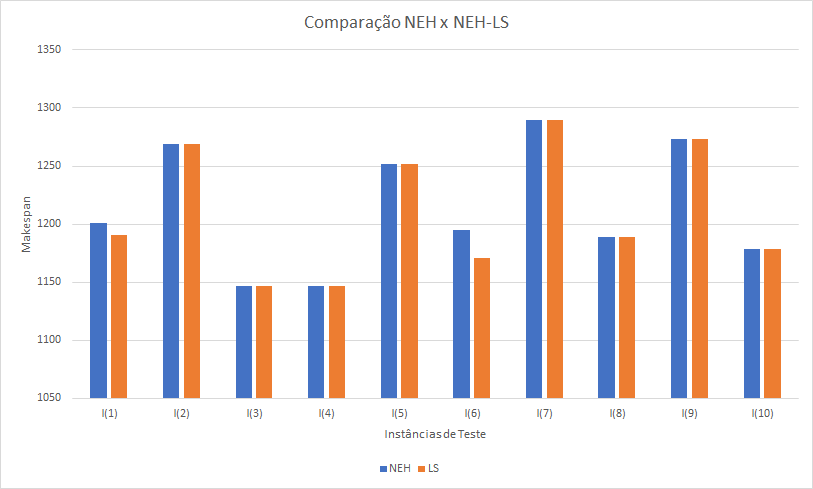

Assim, observa-se que para instâncias I(1) e I(6), o método de _Local Search_ mostrou um aprimoramento em relação ao _NEH_.